In [567]:
%matplotlib inline

import tarfile
import json
import gzip
import pandas as pd
import re
from textblob import TextBlob
from pandas.io.json import json_normalize
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def clean_tweet(tweet):
        '''
        Utility function to clean tweet text by removing links, special characters
        using simple regex statements.
        '''
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())


<h1>Data Preparation</h1>
<h3>Data Preparation #1: Import twitter data</h3>

In [230]:
tar = tarfile.open("../input/2017-09-22.tar.gz", "r:gz")
data = pd.DataFrame()
count=0

'''
        Extracting from twitter data.
'''

for members in tar.getmembers():
    if (count==13):
        f = tar.extractfile(members)
        data = data.append(pd.read_json(f, lines=True))
    count = count + 1


In [314]:
'''
        Compiling hashtags result.
'''
count=0
hashtags=[]
for ent in data['entities']:
    str_hsh=''
    for hsh in ent['hashtags']:
        #print(hsh['text'])
        str_hsh=hsh['text']+';'+str_hsh
    hashtags.append(str_hsh.upper())
    count = count+1
    
'''
        Compiling user screen_name result.
'''
namelist=[]
for x in data['user']:
    namelist.append(x['screen_name'])

twt_data=pd.DataFrame({'screen_name':namelist, 'lang':data['lang'] 
                            ,'retweet_count':data['retweet_count']
                            ,'reply_count':data['reply_count']
                            ,'quote_count':data['quote_count']
                            ,'retweeted_status':data['retweeted_status']
                            ,'hashtags':hashtags
                            ,'created_at':data['created_at']
                           })

In [383]:
data.iloc[0]
#len(twt_data)

contributors                                                               NaN
coordinates                                                               None
created_at                                                 2017-09-22 12:05:02
display_text_range                                                    [0, 140]
entities                     {u'user_mentions': [], u'symbols': [], u'hasht...
extended_entities                                                          NaN
extended_tweet               {u'display_text_range': [0, 135], u'entities':...
favorite_count                                                               0
favorited                                                                False
filter_level                                                               low
geo                                                                       None
id                                                          911199659657498625
id_str                                              

<h3>Data Preparation #2: Import data from previous BotOMeter preprocessing </h3>

In [232]:
bot_data = pd.DataFrame()

for i in range(1,8):
    output="outputbot_"+str(i)+".csv"
    bot_data=bot_data.append(pd.read_csv(output))[['screen_name','english']]

In [233]:
print(len(bot_data))

3232


<h3>Data Preparation #3: Import Sentiment based on Naive Bayes data</h3>
since the analysis process taking time, I decided to separate this process to another notebook file. 

In [234]:
sentiment_data = pd.DataFrame()
sentiment_data = pd.read_csv("sentiment_output.csv")

In [362]:
len(sentiment_data)
data.iloc[185]['text']
#data.iloc[sentiment_data[sentiment_data['p_pos']>0.99].index]['text']


u"As we wait anxiously for Mrs May's #Florence speech, has any Prime Minister in modern history inherited such a Herculean task as #Brexit?"

<h1>Data Merging: Merging the data sources</h1>
since the analysis process taking time, I decided to separate this process to another notebook file. 

In [552]:
sen_dat=twt_data.join(sentiment_data[['class','p_neg','p_pos']])

compiled_data=pd.merge(sen_dat,bot_data, how='left', on=['screen_name'])
print(len(compiled_data))


compiled_data=compiled_data.rename(columns = {
                            'english':'botometer'
                           })
old_compiled_data=compiled_data

4369


<h3>Data checking process: </h3>
since the analysis process taking time, I decided to separate this process to another notebook file. 

In [332]:
assert (len(compiled_data)==len(data)), "Input data and output data has a different count"

<h1>Describing the Data</h1>
since the analysis process taking time, I decided to separate this process to another notebook file. 


In [553]:
old_compiled_data.describe()

,quote_count,reply_count,retweet_count,p_neg,p_pos,botometer
count,4369.0,4369.0,4369.0,4369.000000,4369.000000,4202.000000
mean,0.0,0.0,0.0,0.324850,0.675150,0.387168
std,0.0,0.0,0.0,0.252613,0.252613,0.118586
min,0.0,0.0,0.0,0.000046,0.017756,0.040000
25%,0.0,0.0,0.0,0.108116,0.500000,0.300000
50%,0.0,0.0,0.0,0.268741,0.731259,0.380000
75%,0.0,0.0,0.0,0.500000,0.891884,0.460000
max,0.0,0.0,0.0,0.982244,0.999954,0.880000


In [554]:
old_compiled_data.iloc[0]

created_at               2017-09-22 12:05:02
hashtags            EXCEL;LONDON;EUROPE;MRO;
lang                                      en
quote_count                                0
reply_count                                0
retweet_count                              0
retweeted_status                         NaN
screen_name                     allanwhyte81
class                                    pos
p_neg                             0.00521412
p_pos                               0.994786
botometer                               0.35
Name: 0, dtype: object

In [568]:
#compiled_data=old_compiled_data
#df['Age'] = df.Age.replace(np.NaN, 'Is Null value')
#compiled_data=compiled_data[pd.isnull(compiled_data['botometer'])==True]['botometer']

compiled_data['botometer']=compiled_data.botometer.replace(np.NaN, 0)

<h1>Analysis Part</h1>
since the analysis Part taking time, I decided to separate this process to another notebook file. 

<h3>Analysis 1: sentiment analysis of hashtags</h3>

In [437]:
txt_tag=[]
sntment_tag=[]
for x in range(len(compiled_data)):
    oo=TextBlob(compiled_data.iloc[x]['hashtags']).words
    for p in oo:
        txt_tag.append(p)
        sntment_tag.append(compiled_data.iloc[x]['p_pos'])
    

In [529]:
hashtag_analysis=pd.DataFrame({
            'hashtag':txt_tag,
            'sentimenttag':sntment_tag
            })


lol=hashtag_analysis.groupby(['hashtag'], as_index=False).mean()
lol1=hashtag_analysis.groupby(['hashtag'], sort=True, as_index=False).count().sort_values(by='sentimenttag', ascending=False)

analysis1=pd.merge(lol,lol1, how='left', on=['hashtag'])
analysis1=analysis1.rename(columns = {
                            'sentimenttag_y':'count',
                            'sentimenttag_x':'p_pos'
                           })


In [538]:
analysis1.sort_values(by=['count'], ascending=False)[0:5]

,hashtag,p_pos,count
199,BREXIT,0.704155,1858
556,EU,0.676697,745
1385,REFERENDUM,0.655990,434
575,EUROPE,0.795995,294
654,FLORENCESPEECH,0.778298,230


In [363]:
#len(compiled_data[pd.isnull(compiled_data['retweeted_status'])==True])
#compiled_data[pd.isnull(compiled_data['english'])==True]

<h3>Analysis 2: number of bot</h3>

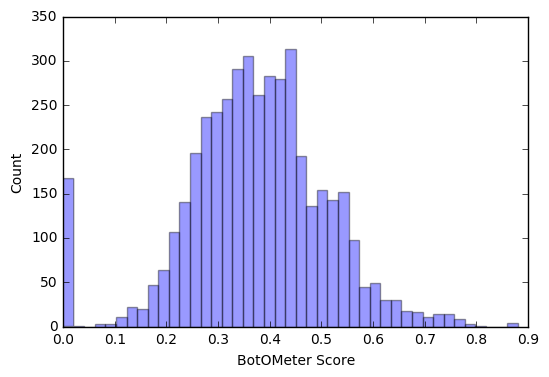

In [573]:
ax=sns.distplot(compiled_data['botometer'], kde=False)
ax.set_xlabel("BotOMeter Score")
ax.set_ylabel("Count")

<h3>Analysis 3: number of bot</h3>
add add ad

In [582]:


time_analysis=pd.DataFrame({
            'created_at':compiled_data['created_at'].dt.strftime('%H:%M'),
            'class':compiled_data['class']
            })

time_analysis

,class,created_at
0,pos,12:05
1,pos,12:05
2,neg,12:05
3,neg,12:05
4,pos,12:05
5,pos,12:05
6,pos,12:05
7,pos,12:05
8,neg,12:05
9,pos,12:05


KeyError: 'class'

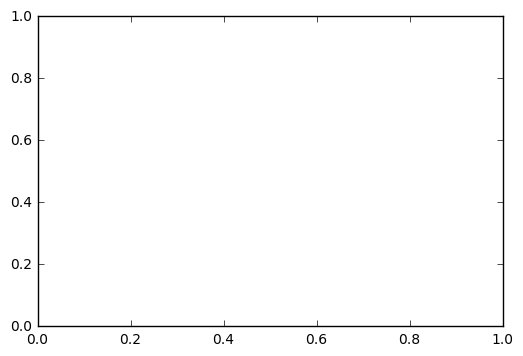

In [576]:


fig, ax = plt.subplots()
new_labels = ['created_at', 'class']
ii=0


for a in [compiled_data['created_at'].dt.strftime('%H%m'), data['class']]:
    sns.distplot(a,  ax=ax, kde=False, label=new_labels[ii])
    ii=ii+1

ax.set_ylabel("Count")
ax.set_xlabel("Amount (GBP)")
ax.set_xlim([0, 55])
ax.set_ylim([0, 60])
ax.legend()

<h1>Hypotheses</h1>

<h3>hypothesis #1:</h3>
Does the sentiment analysis in brexit like negative or positive exactly explain the context of the brexit?what is the meaning of positive sentiment in this case??
naives bayes method classification

<h3>hypothesis #2:</h3>
in order to know the chronology or the spread of thought the data should not only one hour time frame. it's supposed to be more than one hour time frame.

<h3>hypothesis #3:</h3>


In [ ]:
#compiled_data[pd.isnull(compiled_data['retweeted_status'])==False]['retweeted_status']
#print(len(compiled_data))
#compiled_data.loc[4363]

wordfreq=[]

txt=TextBlob(compiled_data.iloc[0]['hashtags']).words
wordfreq = [txt.count(p) for p in txt]
zz = [compiled_data.iloc[0]['p_pos'] for x in txt]

wordfreq_dict=dict(zip(txt,zz))



mydict=Counter(namelist)

for key, value in sorted(mydict.iteritems(), key=lambda (k,v): (v,k), reverse=True):
    print "%s: %s" % (key, value)